In [1]:
#https://medium.com/@kirudang/deep-learning-computer-vision-using-transfer-learning-resnet-18-in-pytorch-skin-cancer-8d5b158893c5

# Set up CUDA in OS
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# Import libabries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import seaborn as sn
import pandas as pd
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision import datasets, models, transforms
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import time
import copy

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

/home/vlad/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-11-15 13:28:26.651754: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-15 13:28:27.671158: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Check version of Pytorch
print(torch. __version__)

2.1.0+cu121


In [3]:
# Setup device agnostic code
device = "cuda"
device

'cuda'

In [4]:
# Find out if a GPU is available
use_cuda = torch.cuda.is_available()
use_cuda

True

In [5]:
# Set up path for data after downloading
train_dir = '/home/vlad/Desktop/ResNet18_Training/'
test_dir = '/home/vlad/Desktop/ResNet18_Test/'


train_classa_dir = "/home/vlad/Desktop/ResNet18_Training/NF/"
train_classb_dir = "/home/vlad/Desktop/ResNet18_Training/FF/"
train_classc_dir = "/home/vlad/Desktop/ResNet18_Training/WEDGE/"
train_classd_dir = "/home/vlad/Desktop/ResNet18_Training/NOISE/"

test_classa_dir = '/home/vlad/Desktop/ResNet18_Test/NF/'
test_classb_dir = '/home/vlad/Desktop/ResNet18_Test/FF/'
test_classc_dir = '/home/vlad/Desktop/ResNet18_Test/WEDGE/'
test_classd_dir = '/home/vlad/Desktop/ResNet18_Test/NOISE/'

This is near-field


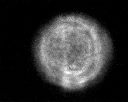

In [6]:
# Display image for reference
white_torch = torchvision.io.read_image('/home/vlad/Desktop/ResNet18_Training/NF/A12_2021-08-20 10_05_22.957.png')
print("This is near-field")
T.ToPILImage()(white_torch)

This is far-field


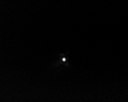

In [7]:
# Display image for reference
wh = torchvision.io.read_image('/home/vlad/Desktop/ResNet18_Training/FF/ATW2_2021-08-20 10_05_27.852.png')
print("This is far-field")
T.ToPILImage()(wh)

In [8]:
# Create transform function
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])
transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
     transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [9]:
# Apply for training and test data
train_dataset = datasets.ImageFolder(train_dir, transforms_train)
test_dataset = datasets.ImageFolder(test_dir, transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=12, shuffle=True, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=12, shuffle=False, num_workers=0)

In [10]:
print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))
class_names = train_dataset.classes
print('Class names:', class_names)

Train dataset size: 8766
Test dataset size: 4383
Class names: ['FF', 'NF', 'NOISE', 'WEDGE']


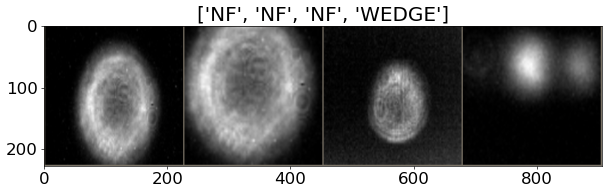

In [11]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})
def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()
# load a batch of train image
iterator = iter(train_dataloader)
# visualize a batch of train image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])

In [12]:
model = models.resnet18(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
num_features = model.fc.in_features 
print('Number of features from pre-trained model', num_features)

Number of features from pre-trained model 512


In [14]:
# Add a fully-connected layer for classification
model.fc = nn.Linear(num_features, 4)
model = model.to(device)

In [15]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.00001, momentum=0.9)

In [16]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [17]:
#### Train model
train_loss=[]
train_accuary=[]
test_loss=[]
test_accuary=[]

num_epochs = 30   #(set no of epochs)
start_time = time.time() #(for showing time)
# Start loop
for epoch in range(num_epochs): #(loop for every epoch)
    print("Epoch {} running".format(epoch)) #(printing message)
    """ Training Phase """
    model.train()    #(training model)
    running_loss = 0.   #(set loss 0)
    running_corrects = 0 
    # load a batch data of images
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device) 
        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        # get loss value and update the network weights
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data).item()
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset) * 100.
    # Append result
    train_loss.append(epoch_loss)
    train_accuary.append(epoch_acc)
    # Print progress
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch+1, epoch_loss, epoch_acc, time.time() -start_time))
    """ Testing Phase """
    model.eval()
    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data).item()
        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = running_corrects / len(test_dataset) * 100.
        # Append result
        test_loss.append(epoch_loss)
        test_accuary.append(epoch_acc)
        # Print progress
        print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch+1, epoch_loss, epoch_acc, time.time()- start_time))

Epoch 0 running
[Train #1] Loss: 0.0565 Acc: 78.8045% Time: 49.5871s
[Test #1] Loss: 0.0337 Acc: 96.0073% Time: 61.7952s
Epoch 1 running
[Train #2] Loss: 0.0270 Acc: 93.8855% Time: 104.5743s
[Test #2] Loss: 0.0182 Acc: 98.7452% Time: 116.0792s
Epoch 2 running
[Train #3] Loss: 0.0196 Acc: 94.9350% Time: 158.1406s
[Test #3] Loss: 0.0116 Acc: 98.7452% Time: 169.5870s
Epoch 3 running
[Train #4] Loss: 0.0158 Acc: 95.6879% Time: 211.4029s
[Test #4] Loss: 0.0085 Acc: 98.7452% Time: 222.8844s
Epoch 4 running
[Train #5] Loss: 0.0137 Acc: 96.2126% Time: 264.7471s
[Test #5] Loss: 0.0065 Acc: 98.7452% Time: 276.2196s
Epoch 5 running
[Train #6] Loss: 0.0125 Acc: 96.1784% Time: 317.9856s
[Test #6] Loss: 0.0048 Acc: 98.7452% Time: 329.4346s
Epoch 6 running
[Train #7] Loss: 0.0112 Acc: 96.5092% Time: 371.6078s
[Test #7] Loss: 0.0045 Acc: 98.7452% Time: 383.0290s
Epoch 7 running
[Train #8] Loss: 0.0102 Acc: 96.7146% Time: 425.0547s
[Test #8] Loss: 0.0039 Acc: 98.9049% Time: 436.4827s
Epoch 8 running
[T

In [18]:
save_path = 'custom-classifier_resnet_18_final.pth'
torch.save(model.state_dict(), save_path)

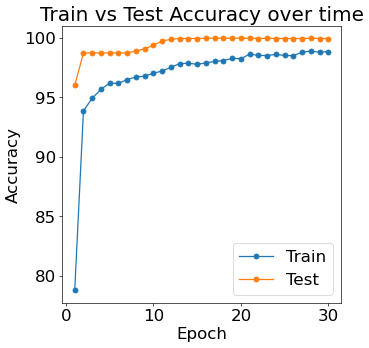

In [19]:
# Plot
plt.figure(figsize=(6,6))
plt.plot(np.arange(1,num_epochs+1), train_accuary,'-o')
plt.plot(np.arange(1,num_epochs+1), test_accuary,'-o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'])
plt.title('Train vs Test Accuracy over time')
plt.show()

In [20]:
# Apply for training and test data
test_dir = '/home/vlad/Desktop/ResNet18_Validation/'


test_dataset = datasets.ImageFolder(test_dir, transforms_test)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=12, shuffle=False, num_workers=0)

In [21]:
# Get data to check on the performance of each label
y_pred = []
y_true = []

num_epochs = 30   #(set no of epochs)
start_time = time.time() #(for showing time)
# Start loop
for epoch in range(num_epochs): #(loop for every epoch)
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs) # Feed Network
            outputs = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
            y_pred.extend(outputs) # Save Prediction
            labels = labels.data.cpu().numpy()
            y_true.extend(labels) # Save Truth

Accuracy on Validation set:  1.0
Confusion matrix: 
 [[ 8670     0     0     0]
 [    0 23910     0     0]
 [    0     0   510     0]
 [    0     0     0 10590]]
Classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8670
           1       1.00      1.00      1.00     23910
           2       1.00      1.00      1.00       510
           3       1.00      1.00      1.00     10590

    accuracy                           1.00     43680
   macro avg       1.00      1.00      1.00     43680
weighted avg       1.00      1.00      1.00     43680



<Axes: title={'center': 'Confusion matrix for beam profile classification '}>

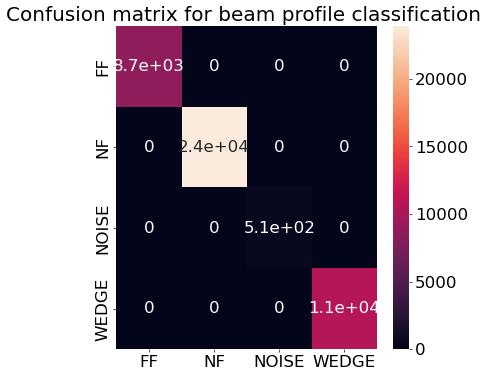

In [22]:
# Visualization and result
# constant for classes
classes = test_dataset.classes
# Build confusion matrix
print("Accuracy on Validation set: ",accuracy_score(y_true, y_pred))
print('Confusion matrix: \n', confusion_matrix(y_true, y_pred))
print('Classification report: \n', classification_report(y_true, y_pred))
# Plot
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (7,7))
plt.title("Confusion matrix for beam profile classification ")
sn.heatmap(df_cm, annot=True)